<a href="https://colab.research.google.com/github/KJanzon/Project-CNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Fake News

Task:
- Train the model on training data set.
- Validate model on training data set.
- Predict real/fake news on 'testing_data' data set.
-- label: 0 if the news is fake, 1 if the news is real.


Steps:

- Load data from google drive
- Data pre-processing
-- data cleaning
-- stop words removal

- Train/Validation split (on training data set)
- Plot validation result
-- training/validation loss
-- training/validation accuracy






In [281]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np



In [282]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [283]:
from google.colab import drive
import os

drive.mount('/content/drive')


# Define paths to the CSV files
training_data_path = "/content/drive/My Drive/training_data_lowercase.csv"
testing_data_path = "/content/drive/My Drive/testing_data_lowercase_nolabels.csv"


# Load datasets
train_df = pd.read_csv(training_data_path, sep='\t', header=None, names=['label', 'text'])
test_df = pd.read_csv(testing_data_path, sep='\t', header=None, names=['label','text'])

# Display first few rows
print("Training Data Sample:")
print(train_df.head())

print("\nTesting Data Sample:")
print(test_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data Sample:
   label                                               text
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...

Testing Data Sample:
  label                                               text
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [284]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

print("\nMissing values in testing data:")
print(test_df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows in training data:", train_df.duplicated().sum())
print("Number of duplicate rows in testing data:", test_df.duplicated().sum())

# Display column names
print("\nTraining Data Columns:", train_df.columns)
print("Testing Data Columns:", test_df.columns)


Missing values in training data:
label    0
text     0
dtype: int64

Missing values in testing data:
label    0
text     0
dtype: int64

Number of duplicate rows in training data: 1946
Number of duplicate rows in testing data: 775

Training Data Columns: Index(['label', 'text'], dtype='object')
Testing Data Columns: Index(['label', 'text'], dtype='object')


In [285]:
# Remove duplicate rows
#train_df = train_df.drop_duplicates()
#test_df = test_df.drop_duplicates()

# Drop missing values
#train_df = train_df.dropna()
#test_df = test_df.dropna()

# Ensure labels are integers
#train_df['label'] = train_df['label'].astype(int)


Define Text Processing Functions


In [286]:
from nltk.stem import PorterStemmer
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer()


def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [word for word in tokens if word not in stopwords.words('english')]

def lemmatize_tokens(tokens):
    """Apply lemmatization to a list of tokens."""
    return [lemmatizer.lemmatize(word) for word in tokens]

def stem_tokens(tokens):
    """Apply stemming to a list of tokens."""
    return [stemmer.stem(word) for word in tokens]

def clean_text(text):
    """Clean and preprocess text by removing special characters, numbers, stopwords, and applying lemmatization."""
    #text = str(text)  # Ensure it's a string
    #text = re.sub(r'\W', ' ', text)  # Remove special characters
    #text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces

    #text = re.sub(r'\d+', ' ', text)  # Remove numbers
    #text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    #tokens = word_tokenize(text)  # Tokenize
    #tokens = remove_stopwords(tokens)  # Remove stopwords
    #tokens = lemmatize_tokens(tokens)  # Apply lemmatization
    #tokens = stem_tokens(tokens)
    return text

In [287]:
# Step 5: Apply Text Cleaning
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Step 6: Save Cleaned Data
train_df.to_csv("/content/training_data_cleaned.csv", index=False)
test_df.to_csv("/content/testing_data_cleaned.csv", index=False)

In [288]:
# Ensure labels are integers
train_df['label'] = train_df['label'].astype(int)

# Check class distribution
print(train_df['label'].value_counts())


label
0    17572
1    16580
Name: count, dtype: int64


#  Convert Text to Numerical Representation (TF-IDF)

In [289]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Increase number of features
    ngram_range=(1,2),  # Use unigrams and bigrams
    min_df=2,  # Ignore very rare words
    max_df=0.95  # Ignore very common words
)
X = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
#X = tfidf_vectorizer.fit_transform(train_df['text'])
y = train_df['label']


#Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Train model

In [290]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [291]:
#Evaluate Model on Training and Validation Data
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
#print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred))
val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_report_df = pd.DataFrame(val_report).transpose()
val_report_df.to_csv("/content/validation_classification_report.csv", index=True)
print("Classification report saved successfully!", val_report)


Training Accuracy: 0.9617144321218111
Validation Accuracy: 0.9470062948323817
Classification report saved successfully! {'0': {'precision': 0.9583212735166425, 'recall': 0.9382261263814111, 'f1-score': 0.9481672394043528, 'support': 3529.0}, '1': {'precision': 0.9354265402843602, 'recall': 0.9563900666262871, 'f1-score': 0.9457921533393232, 'support': 3302.0}, 'accuracy': 0.9470062948323817, 'macro avg': {'precision': 0.9468739069005014, 'recall': 0.9473080965038492, 'f1-score': 0.946979696371838, 'support': 6831.0}, 'weighted avg': {'precision': 0.9472543127300819, 'recall': 0.9470062948323817, 'f1-score': 0.9470191594472853, 'support': 6831.0}}


<ipython-input-292-2c1c648efe4f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Training', 'Validation'], y=[train_accuracy, val_accuracy], palette='coolwarm')


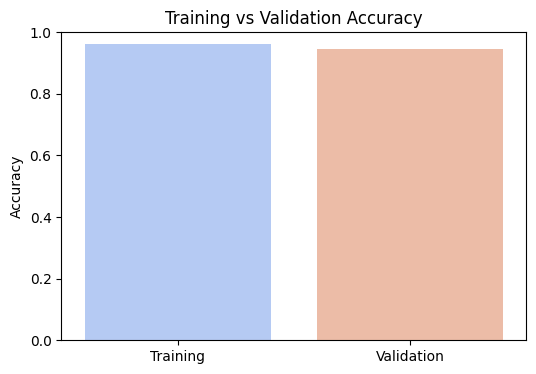

In [292]:
#Compare Training and Validation Accuracy
plt.figure(figsize=(6,4))
sns.barplot(x=['Training', 'Validation'], y=[train_accuracy, val_accuracy], palette='coolwarm')
plt.title("Training vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


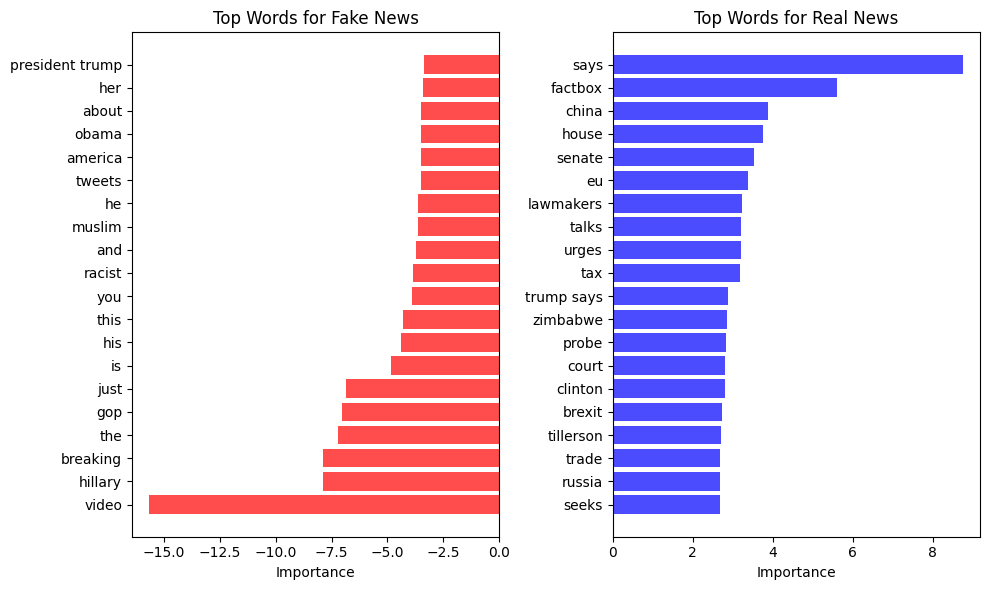

In [293]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importances = model.coef_.flatten()

N = 20
fake_indices = np.argsort(feature_importances)[:N]
real_indices = np.argsort(feature_importances)[-N:]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.barh([feature_names[i] for i in fake_indices], feature_importances[fake_indices], color='red', alpha=0.7)
plt.xlabel("Importance")
plt.title("Top Words for Fake News")

plt.subplot(1,2,2)
plt.barh([feature_names[i] for i in real_indices], feature_importances[real_indices], color='blue', alpha=0.7)
plt.xlabel("Importance")
plt.title("Top Words for Real News")

plt.tight_layout()
plt.show()


Comments on chart:
the word "say" is often highly correlated with real news because it is frequently used in news articles for attributions (e.g., "The president says...", "Experts say...", "The report says...").

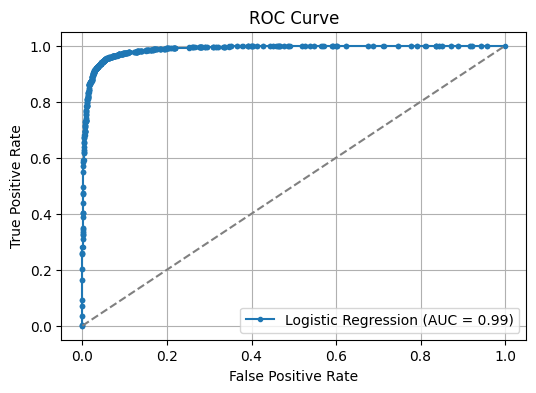

In [294]:
from sklearn.metrics import roc_curve, roc_auc_score


y_scores = model.decision_function(X_val)

fpr, tpr, _ = roc_curve(y_val, y_scores)
auc_score = roc_auc_score(y_val, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, marker='.', label=f"Logistic Regression (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Comment:
AUC = 0.98 → The model has excellent predictive performance.
The curve is steep and close to (0,1), meaning a high True Positive Rate (TPR) and low False Positive Rate (FPR).
Far above the diagonal line, indicating the model is far better than random guessing.

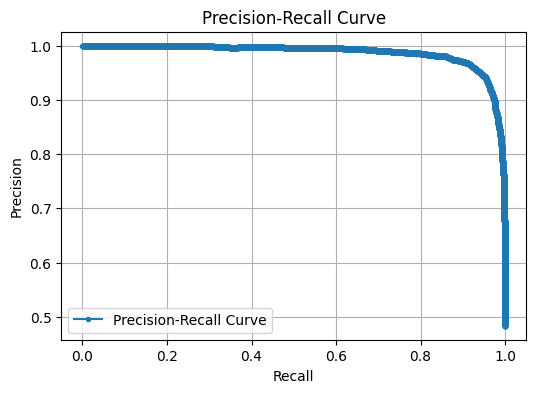

In [295]:
from sklearn.metrics import precision_recall_curve

y_scores = model.decision_function(X_val)
precisions, recalls, _ = precision_recall_curve(y_val, y_scores)

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


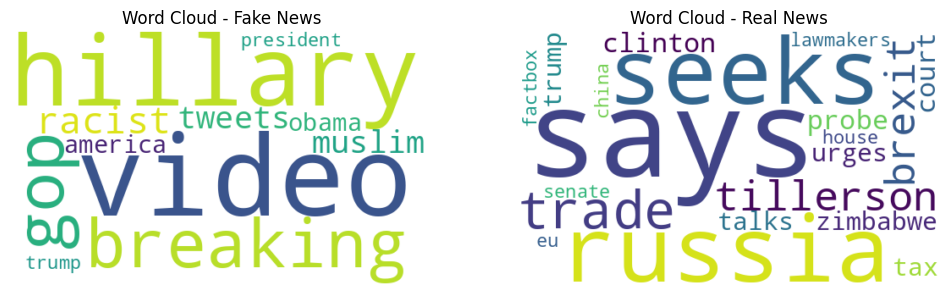

In [296]:
from wordcloud import WordCloud

# Generate word clouds for fake and real news
fake_wordcloud = WordCloud(width=500, height=300, background_color='white').generate(' '.join([feature_names[i] for i in fake_indices]))
real_wordcloud = WordCloud(width=500, height=300, background_color='white').generate(' '.join([feature_names[i] for i in real_indices]))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Fake News")

plt.subplot(1,2,2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Real News")

plt.show()

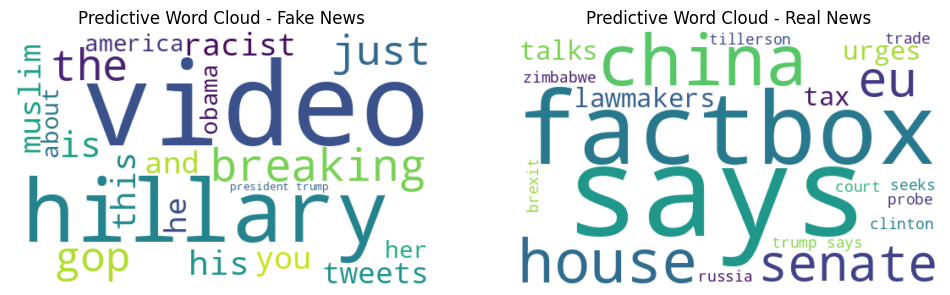

In [297]:
#word cloud words based on predictive power

fake_wordcloud = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(
    {feature_names[i]: abs(feature_importances[i]) for i in fake_indices})
real_wordcloud = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(
    {feature_names[i]: abs(feature_importances[i]) for i in real_indices})

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Predictive Word Cloud - Fake News")

plt.subplot(1,2,2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Predictive Word Cloud - Real News")

plt.show()

# Make predictions on test set

In [298]:
test_X = tfidf_vectorizer.transform(test_df['cleaned_text'])
test_df['label'] = model.predict(test_X)

# Step 11: Save Predictions
test_df.to_csv("/content/testing_data_predicted.csv", index=False)

print("Predictions saved successfully!")

Predictions saved successfully!


Visualization of Predictions


<ipython-input-299-812381b9ec13>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_df['label'], palette='coolwarm')


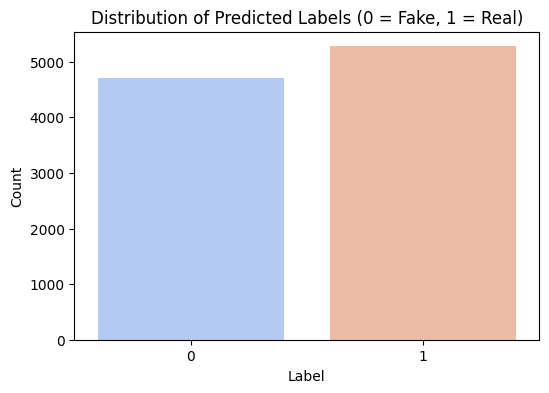

Sample Predictions:
                                                text  label
0  copycat muslim terrorist arrested with assault...      0
1  wow! chicago protester caught on camera admits...      0
2   germany's fdp look to fill schaeuble's big shoes      1
3  mi school sends welcome back packet warning ki...      0
4  u.n. seeks 'massive' aid boost amid rohingya '...      1
5  did oprah just leave ‚nasty‚ hillary wishing s...      0
6  france's macron says his job not 'cool' cites ...      1
7  flashback: chilling ‚60 minutes‚ interview wit...      0
8  spanish foreign ministry says to expel north k...      1
9  trump says cuba 'did some bad things' aimed at...      1


In [299]:


# Bar Chart of Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=test_df['label'], palette='coolwarm')
plt.title("Distribution of Predicted Labels (0 = Fake, 1 = Real)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Display Sample Predictions
print("Sample Predictions:")
print(test_df[['text', 'label']].head(10))
